In [1]:
import torch
import torchvision
import torchvision.transforms as tr    # 이미지 전처리 기능 제공
from torch.utils.data import DataLoader, Dataset    # 데이터를 모델에 사용할 수 있도록 정리

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 4.3.1
transf = tr.Compose([tr.Resize(16), tr.ToTensor()])    # 원하는 전처리를 차례대로 입력

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)
testset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)

print(trainset[0][0].size())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 16, 16])


In [3]:
trainloader = DataLoader(trainset, batch_size=50, shuffle=True)
testloader = DataLoader(testset, batch_size=50, shuffle=False)
# DataLoader는 데이터를 미니 배치 형태로 변환
len(trainloader), len(testloader)

(1000, 1000)

In [4]:
images, labels = iter(trainloader).next()
print(images.size())    # [배치크기, 채널수, 너비, 높이]

torch.Size([50, 3, 16, 16])


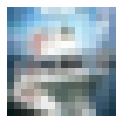

In [7]:
oneshot = images[1].permute(1,2,0).numpy()    # permute()로 기존 차원의 위치를 변경
plt.figure(figsize=(2,2))
plt.imshow(oneshot)
plt.axis("off")
plt.show()

In [8]:
# 4.3.2 같은 클래스 별로 폴더 정리한 경우
transf = tr.Compose([tr.Resize(128), tr.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='./class', transform=transf)
trainloader = DataLoader(trainset, batch_size=1, shuffle=False)

FileNotFoundError: ignored

In [10]:
# 4.3.3 정리되지 않은 커스텀 데이터 
train_images = np.random.randint(256, size=(100, 32, 32, 3))/255
train_labels = np.random.randint(2, size=(100, 1))

class TensorData(Dataset):

  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.x_data = self.x_data.permute(0, 3, 1, 2)
    self.y_data = torch.LongTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

In [11]:
train_data = TensorData(train_images, train_labels)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

In [12]:
# 커스텀 데이터와 커스텀 전처리 사용하기
class ToTensor:
  def __call__(self, sample):
    inputs, labels = sample
    inputs = torch.FloatTensor(inputs)
    inputs = inputs.permute(2,0,1)
    return inputs, torch.LongTensor(labels)

In [13]:
class CutOut:

  def __init__(self, ratio=.5):
    self.ratio = int(1/ratio)

  def __call__(self, sample):
    inputs, labels = sample
    active = int(np.random.randint(0, self.ratio, 1))

    if active ==0:
      _, w, h = inputs.size()
      min_len = min(w, h)
      box_size = int(min_len//4)
      idx = int(np.random.randint(0, min_len-box_size, 1))
      inputs[:, idx:idx+box_size, idx:idx+box_size] = 0

    return inputs, labels

In [17]:
class MyDataset(Dataset):

  def __init__(self, x_data, y_data, transform=None):
    self.x_data = x_data
    self.y_data = y_data
    self.transform = transform
    self.len = len(y_data)
    self.tensor = ToTensor()

  def __getitem__(self, index):
    sample = self.x_data[index], self.y_data[index]

    if self.transform:
      sample = self.transform(sample)
    else:
      sample = self.tensor(sample)
    return sample

  def __len__(self):
    return self.len

In [18]:
trans = tr.Compose([ToTensor(), CutOut()])
dataset1 = MyDataset(train_images, train_labels, transform=trans)
train_loader1 = DataLoader(dataset1, batch_size=10, shuffle=True)

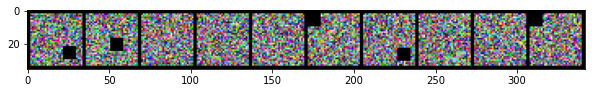

In [19]:
images1, labels1 = iter(train_loader1).next()

def imshow(img):
  plt.figure(figsize=(10, 100))
  plt.imshow(img.permute(1,2,0).numpy())
  plt.show()

imshow(torchvision.utils.make_grid(images1, nrow=10))

In [20]:
# 4.3.5 커스텀 데이터와 파이토치 제공 전처리 사용하기

class MyTransform:

  def __call__(self, sample):
    inputs, labels = sample
    inputs = torch.FloatTensor(inputs)
    inputs =inputs.permute(2,0,1)
    labels = torch.FloatTensor(labels)

    transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])
    final_output = transf(inputs)

    return final_output, labels

In [21]:
dataset2 = MyDataset(train_images, train_labels, transform=MyTransform())
train_loader2 = DataLoader(dataset2, batch_size=10, shuffle=True)

In [22]:
class CutOut:

  def __init__(self, ratio=.5):
    self.ratio = int(1/ratio)

  def __call__(self, inputs):
    active = int(np.random.randint(0, self.ratio, 1))

    if active ==0:
      _, w, h = inputs.size()
      min_len = min(w, h)
      box_size = int(min_len//4)
      idx = int(np.random.randint(0, min_len-box_size, 1))
      inputs[:, idx:idx+box_size, idx:idx+box_size] = 0

    return inputs

transf = tr.Compose([tr.Resize(128), tr.ToTensor(), CutOut()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)

Files already downloaded and verified


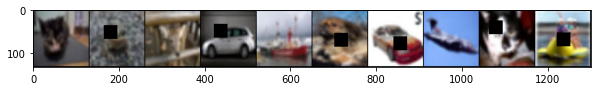

torch.Size([10, 3, 128, 128])


In [24]:
trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images, nrow=10))
print(images.size())